In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

#import vgg16_new as vgg16
import os
import time
import numpy as np
from IPython.display import clear_output
import sys
import csv
BATCH_SIZE = 90
IMAGE_HEIGHT  = 224    #960
IMAGE_WIDTH   = 224 

def _compute_longer_edge(height, width, new_shorter_edge):
    return tf.cast(width*new_shorter_edge/height, tf.int32)

def parse_example_proto(example_serialized):
    """Parses an Example proto containing a training example of an image.

    The output of the build_image_data.py image preprocessing script is a dataset
    containing serialized Example protocol buffers. Each Example proto contains
    the following fields:

        image/height: 462
        image/width: 581
        image/colorspace: 'RGB'
        image/channels: 3
        image/class/label: 615
        image/class/synset: 'n03623198'
        image/class/text: 'knee pad'
        image/object/bbox/xmin: 0.1
        image/object/bbox/xmax: 0.9
        image/object/bbox/ymin: 0.2
        image/object/bbox/ymax: 0.6
        image/object/bbox/label: 615
        image/format: 'JPEG'
        image/filename: 'ILSVRC2012_val_00041207.JPEG'
        image/encoded: <JPEG encoded string>

    Args:
        example_serialized: scalar Tensor tf.string containing a serialized
        Example protocol buffer.

    Returns:
        image_buffer: Tensor tf.string containing the contents of a JPEG file.
        label: Tensor tf.int32 containing the label.
        bbox: 3-D float Tensor of bounding boxes arranged [1, num_boxes, coords]
        where each coordinate is [0, 1) and the coordinates are arranged as
        [ymin, xmin, ymax, xmax].
        text: Tensor tf.string containing the human-readable label.
    """
    # Dense features in Example proto.
    feature_map = {
        'image/encoded': tf.FixedLenFeature([], dtype=tf.string,
                                            default_value=''),
        'image/class/label': tf.FixedLenFeature([1], dtype=tf.int64,
                                                default_value=-1),
        'image/class/text': tf.FixedLenFeature([], dtype=tf.string,
                                               default_value=''),
    }

    features = tf.parse_single_example(example_serialized, feature_map)
    label = tf.cast(features['image/class/label'], dtype=tf.int32)
    return features['image/encoded'], label, features['image/class/text']

os.environ["CUDA_VISIBLE_DEVICES"] = ""
data_dir ='/mnt/data1/ILSVRC2012/tfrecords/'
tf_record_pattern = os.path.join(data_dir, '%s-*' % 'train')
data_files = tf.gfile.Glob(tf_record_pattern)
filename_queue = tf.train.string_input_producer(data_files,
                                                shuffle=True,
                                                capacity=16)
reader = tf.TFRecordReader()
_, example_serialized = reader.read(filename_queue)

image_buffer, label_index, text = parse_example_proto(example_serialized)
train_image = tf.image.decode_jpeg(image_buffer, channels=3)
shape = tf.shape(train_image)
height = shape[0]
width = shape[1]
new_shorter_edge = tf.constant(256, dtype=tf.int32)

height_smaller_than_width = tf.less_equal(height, width)
new_height_and_width = tf.cond(
    height_smaller_than_width,
    lambda: (new_shorter_edge, _compute_longer_edge(height, width, new_shorter_edge)),
    lambda: (_compute_longer_edge(width, height, new_shorter_edge), new_shorter_edge)
    )
size = tf.cast([new_height_and_width[0], new_height_and_width[1]], tf.int32)
train_image = tf.image.resize_images(train_image, size)
size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH, 3], tf.int32)
train_image = tf.random_crop(train_image, size)
train_image = tf.image.random_flip_left_right(train_image)
train_image = tf.cast(train_image, tf.float32)/255.

train_image_batch, train_label_batch = tf.train.shuffle_batch([train_image, label_index], batch_size=BATCH_SIZE,
                                                                  capacity = 1000 + 3*BATCH_SIZE, 
                                                                  min_after_dequeue = 1000)
with tf.device('/cpu:0'):
    sess = tf.Session()
    init_op = tf.group(tf.initialize_all_variables(),
                           tf.initialize_local_variables())
    sess.run(init_op)
    threads = tf.train.start_queue_runners(sess=sess)

14234
Iteration:15

KeyboardInterrupt: 

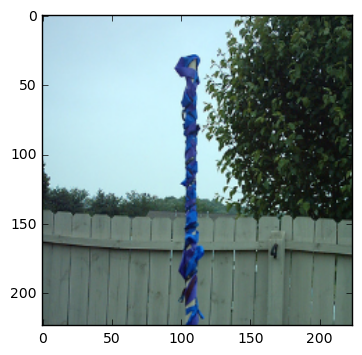

In [2]:
for epoch in xrange(5):
    epoch_start_time = time.time()
    print((1281144 / BATCH_SIZE))
        #print((2500 / BATCH_SIZE))
    for i in xrange((1281144/ BATCH_SIZE)):
        train_imbatch, train_labatch = sess.run([train_image_batch, train_label_batch])
        sys.stdout.write('\r' + "Iteration:" + str(i))
        sys.stdout.flush()
        if (i) % 1000 == 0:
            plt.imshow(train_imbatch[9])
    print 'Time Elapsed for Epoch:' + str(epoch + 1) + ' is ' + str(
            (time.time() - epoch_start_time) / 60.) + ' minutes'
